# Librerias

In [1]:
import pandas as pd
import numpy as np
import re # expresiones regulares (regex)
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.tokenize import TreebankWordTokenizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from mpl_toolkits import mplot3d
from sklearn.preprocessing import MaxAbsScaler
import pyLDAvis.gensim_models
import gensim
from gensim import corpora
from gensim.models import LdaModel
import random

# Preprocesamiento

* Eliminamos stopwords
* lematizamos
* Normalizamos el texto (quitamos mayúsculas y signos de puntuación)
* Vectorizamos y hacemos n-gramas
* Usamos SVD para ver cuantos topicos pueden tener los documentos

In [2]:
# Leer archivo .csv 
df = pd.read_csv('mañaneras.csv')

textoPrueba = df[['description']].copy() # Pongo .copy() porque cuando intentas 
                                  # quitar las stopwords sale un warning.
# textoPrueba = textoPrueba.head(1000)

print(textoPrueba.shape[0])
textoPrueba.head(10)

233


,description
0,Andrés Manuel López Obrador ofrece su primera ...
1,Esta mañana dimos a conocer el trabajo coordin...
2,El presupuesto 2019 está planeado para cumplir...
3,Celebramos la aprobación del Presupuesto de Eg...
4,En la primera conferencia matutina del año pre...
5,Hoy anunciamos que esta semana iniciará la dis...
6,"Hoy informamos que, como parte del Plan contra..."
7,Hoy informamos que la delegación de representa...
8,Avanzamos en la regularización del suministro ...
9,Hoy informamos sobre la estrategia que impleme...


Eliminamos stopwords

In [3]:
# Función para eliminar stopwords en español

def noStopwords(text):
    
    stopWord = stopwords.words('spanish')
    stopWord.extend(['mil', 'millón', 'millon', 'pregunta', 'respuesta', 'nacional', 'México', 'gobierno', 'país', 'mexico'])
    sw_es = set(stopWord)

    text = ' '.join([word for word in text.split() if word.lower() not in sw_es])
    
    return text


In [4]:
textoPrueba['description'] = textoPrueba['description'].apply(noStopwords)
textoPrueba.head()

,description
0,Andrés Manuel López Obrador ofrece primera con...
1,mañana dimos conocer trabajo coordinado México...
2,presupuesto 2019 planeado cumplir compromisos....
3,Celebramos aprobación Presupuesto Egresos Fede...
4,primera conferencia matutina año presentamos C...


Aplicamos lematización

In [5]:
# Función para lematizar al texto
def lemmatize_text(text):

    # Cargamos el módulo de español
    nlp = spacy.load("es_core_news_lg")

    # nlp crea una pipeline que le adhiere metadata que la paquetería spacy usa
    doc = nlp(text)

    lemmatized_text = " ".join([token.lemma_ for token in doc])
    
    return lemmatized_text

In [6]:
textoPrueba['description'] = textoPrueba['description'].apply(lemmatize_text)
textoPrueba.head()

,description
0,Andrés Manuel López Obrador ofrecer primero co...
1,mañana dar conocer trabajo coordinado México C...
2,presupuesto 2019 planeado cumplir compromiso ....
3,celebrar aprobación Presupuesto Egresos Federa...
4,primero conferencia matutino año presentar con...


Aplicamos otra vez la eliminación de stopwords para quitar palabras que no son stopwords pero aparecen mucho en los documentos sin dar información importante.

In [7]:
textoPrueba['description'] = textoPrueba['description'].apply(noStopwords)
textoPrueba.head()

,description
0,Andrés Manuel López Obrador ofrecer primero co...
1,mañana dar conocer trabajo coordinado México C...
2,presupuesto 2019 planeado cumplir compromiso ....
3,celebrar aprobación Presupuesto Egresos Federa...
4,primero conferencia matutino año presentar con...


Normalizamos el texto, quitamos mayúsculas y signos de puntuación

In [8]:
# Función para normalizar el texto

def noPuntuacion(text):

    text = text.lower()

    text = re.sub('[áäàâ]', 'a', text)
    text = re.sub('[éëèê]', 'e', text)
    text = re.sub('[íïìî]', 'i', text)
    text = re.sub('[óöòô]', 'o', text)
    text = re.sub('[úüùû]', 'u', text)

    return re.findall(r'[a-zñ]+', text)

In [9]:
textoPrueba['description'] = textoPrueba['description'].apply(noPuntuacion).apply(lambda x: " ".join(x))
textoPrueba.head()

,description
0,andres manuel lopez obrador ofrecer primero co...
1,mañana dar conocer trabajo coordinado mexico c...
2,presupuesto planeado cumplir compromiso garant...
3,celebrar aprobacion presupuesto egresos federa...
4,primero conferencia matutino año presentar con...


Aplicamos stemming (Optamos por no ponerlo)

In [10]:
# # Función para aplicar stemming al texto

# def stemmiar(text):

#     stemmer = SnowballStemmer('spanish')

#     return ' '.join([stemmer.stem(word) for word in text.split()])

In [11]:
# textoPrueba['text'] = textoPrueba['text'].apply(stemmiar)
# textoPrueba.head()

Vectorizamos y hacemos n-gramas

In [12]:
# Creamos una instancia que hará la vectorización TF-IDF
vect = TfidfVectorizer()

# Tokenizamos como Penn Treebank
tokenizer = TreebankWordTokenizer()
vect.set_params(tokenizer=tokenizer.tokenize)

# Incluimos 1-grams y 2-grams
vect.set_params(ngram_range=(1, 3))

# Ignoramos términos que aparecen en más del 70% de los documentos
vect.set_params(max_df=0.7) 

# Solo mantenemos los términos que aparecen en al menos 2 documentos
vect.set_params(min_df=2) 

TfidfVectorizer(max_df=0.7, min_df=2, ngram_range=(1, 3),
                tokenizer=<bound method TreebankWordTokenizer.tokenize of <nltk.tokenize.treebank.TreebankWordTokenizer object at 0x000001640592B850>>)

In [13]:
# Lo aplicamos
vectFit = vect.fit_transform(textoPrueba['description']) 
vectFit 

c:\Users\julio\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<233x32007 sparse matrix of type '<class 'numpy.float64'>'
	with 203873 stored elements in Compressed Sparse Row format>

In [14]:
print(vectFit[1])

  (0, 196)	0.10676302299857396
  (0, 18587)	0.08721439725001354
  (0, 20131)	0.07753788060904421
  (0, 16588)	0.10102931435187348
  (0, 24690)	0.08486689744155455
  (0, 10147)	0.0898757730318691
  (0, 13303)	0.09658190440824488
  (0, 6462)	0.10676302299857396
  (0, 2091)	0.10676302299857396
  (0, 17251)	0.10102931435187348
  (0, 17697)	0.10102931435187348
  (0, 26897)	0.08721439725001354
  (0, 14035)	0.10102931435187348
  (0, 22790)	0.10102931435187348
  (0, 23781)	0.10676302299857396
  (0, 2265)	0.10676302299857396
  (0, 13246)	0.10676302299857396
  (0, 22785)	0.10676302299857396
  (0, 19920)	0.10676302299857396
  (0, 5240)	0.10676302299857396
  (0, 18992)	0.08086738752456595
  (0, 30214)	0.10676302299857396
  (0, 18351)	0.09294810589671403
  (0, 28778)	0.053237553320846065
  (0, 3029)	0.10102931435187348
  :	:
  (0, 26553)	0.07296029117581536
  (0, 6455)	0.09092127292339142
  (0, 26377)	0.03274888618587159
  (0, 13237)	0.059584563046293657
  (0, 19916)	0.047390922488826946
  (0, 2518

Descomposicion por valores singulares (SVD)

Hacemos z-score normalizacion

In [15]:
# Creamos la instancia 
scaler = StandardScaler(with_mean=False)
# Calculamos el promedio y la desviacion estandar
scaler.fit(vectFit)
# Re escalamos
vectFitScaled = scaler.transform(vectFit)

print(vectFitScaled[0])

  (0, 15390)	11.528445173696262
  (0, 28764)	11.528445173696262
  (0, 6150)	14.55508828487757
  (0, 27222)	14.27078241178832
  (0, 18163)	15.009096279143284
  (0, 23471)	14.555609411221445
  (0, 23258)	14.64977864160397
  (0, 23257)	14.525289656191005
  (0, 6143)	11.448304954835605
  (0, 23672)	13.094621058913878
  (0, 20752)	13.094621058913878
  (0, 17910)	14.596239610333823
  (0, 1484)	14.596239610333823
  (0, 7061)	7.138131303524573
  (0, 15122)	4.184745973965894
  (0, 15389)	11.528445173696262
  (0, 28763)	11.528445173696262
  (0, 6149)	14.55508828487757
  (0, 29791)	14.27078241178832
  (0, 27221)	14.01000088684429
  (0, 18162)	15.009096279143284
  (0, 23470)	14.555609411221445
  (0, 18156)	14.64977864160397
  (0, 18155)	14.525289656191005
  (0, 23252)	12.772705223385554
  :	:
  (0, 17467)	14.227659753402996
  (0, 17909)	14.15029625932463
  (0, 1483)	14.596239610333823
  (0, 29770)	5.212519446368822
  (0, 7021)	2.518918371288002
  (0, 6422)	7.945273732871675
  (0, 8363)	3.394821338

In [16]:
# vectFitScaled = vectFitScaled.transpose()
# vectFitScaled

Aplicamos TruncatedSVD

In [17]:
# Creamos instancia de la clase TruncatedSVD
dimReduction = TruncatedSVD(n_components = textoPrueba.shape[0], random_state = 2)

In [18]:
# Ajustamos la transfromacion con nuestros datos
dimReduction.fit(vectFitScaled)

TruncatedSVD(n_components=233, random_state=2)

In [19]:
# Reducimos la dimensionalidad
dataReduction = dimReduction.transform(vectFitScaled)

Calculamos la variancia explicada

In [20]:
print("Variancia explicada por los 36,755 componentes = " \
        + str(sum(dimReduction.explained_variance_ratio_ * 100)))

Variancia explicada por los 36,755 componentes = 99.99999999999999


In [21]:
dimReduction.explained_variance_ratio_ * 100

array([1.74916803e-01, 1.04229257e+00, 8.30859908e-01, 7.28655351e-01,
       7.04736584e-01, 6.67996105e-01, 6.41921892e-01, 6.37787196e-01,
       6.29625796e-01, 6.17849956e-01, 6.13541141e-01, 6.06266624e-01,
       5.98242025e-01, 5.95704856e-01, 5.92858353e-01, 5.84677278e-01,
       5.82560857e-01, 5.74048200e-01, 5.73493601e-01, 5.72058223e-01,
       5.70561749e-01, 5.65931931e-01, 5.63408914e-01, 5.60477584e-01,
       5.58657663e-01, 5.52715342e-01, 5.49596663e-01, 5.48597020e-01,
       5.47675834e-01, 5.47457059e-01, 5.42314841e-01, 5.39613962e-01,
       5.37945108e-01, 5.36128186e-01, 5.35508094e-01, 5.32736585e-01,
       5.31253920e-01, 5.28059866e-01, 5.25093105e-01, 5.22984602e-01,
       5.20713154e-01, 5.19387469e-01, 5.18316800e-01, 5.14850969e-01,
       5.13655133e-01, 5.11390642e-01, 5.10061177e-01, 5.09438790e-01,
       5.08548834e-01, 5.05936767e-01, 5.04836397e-01, 5.03241834e-01,
       5.02455387e-01, 5.01515342e-01, 4.99959107e-01, 4.97972940e-01,
      

In [22]:
np.cumsum(dimReduction.explained_variance_ratio_ * 100)

array([  0.1749168 ,   1.21720937,   2.04806928,   2.77672463,
         3.48146122,   4.14945732,   4.79137921,   5.42916641,
         6.0587922 ,   6.67664216,   7.2901833 ,   7.89644993,
         8.49469195,   9.09039681,   9.68325516,  10.26793244,
        10.8504933 ,  11.4245415 ,  11.9980351 ,  12.57009332,
        13.14065507,  13.706587  ,  14.26999591,  14.8304735 ,
        15.38913116,  15.9418465 ,  16.49144317,  17.04004019,
        17.58771602,  18.13517308,  18.67748792,  19.21710188,
        19.75504699,  20.29117518,  20.82668327,  21.35941986,
        21.89067378,  22.41873364,  22.94382675,  23.46681135,
        23.9875245 ,  24.50691197,  25.02522877,  25.54007974,
        26.05373487,  26.56512552,  27.07518669,  27.58462548,
        28.09317432,  28.59911108,  29.10394748,  29.60718932,
        30.1096447 ,  30.61116004,  31.11111915,  31.60909209,
        32.10478413,  32.59818578,  33.09009413,  33.58087397,
        34.07047721,  34.55958964,  35.04693241,  35.53

Text(0, 0.5, 'Variancia explicada (%)')

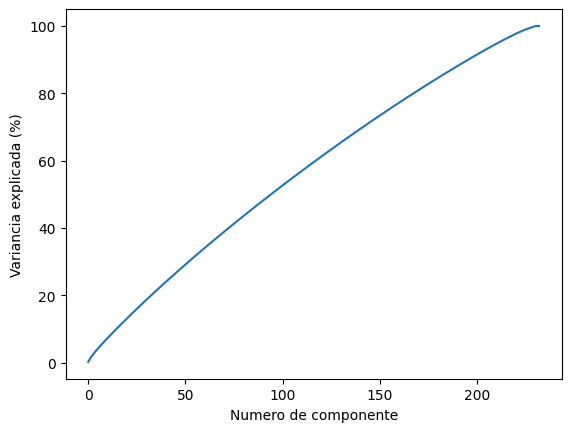

In [23]:
plt.plot(np.cumsum(dimReduction.explained_variance_ratio_ * 100))
plt.xlabel("Numero de componente")
plt.ylabel("Variancia explicada (%)")

Graficamos los componentes del TruncatedSVD con 2 componentes

In [24]:
# Creamos instancia de la clase TruncatedSVD
dimReduction2 = TruncatedSVD(n_components = 2, random_state = 2)

# Ajustamos la transfromacion con nuestros datos
dimReduction2.fit(vectFitScaled)

# Reducimos la dimensionalidad
dataReduction2 = dimReduction2.transform(vectFitScaled)

print("Variancia explicada por 2 componentes = " \
        + str(sum(dimReduction2.explained_variance_ratio_ * 100)))

Variancia explicada por 2 componentes = 1.212278925854538


Text(0, 0.5, 'Segundo componente')

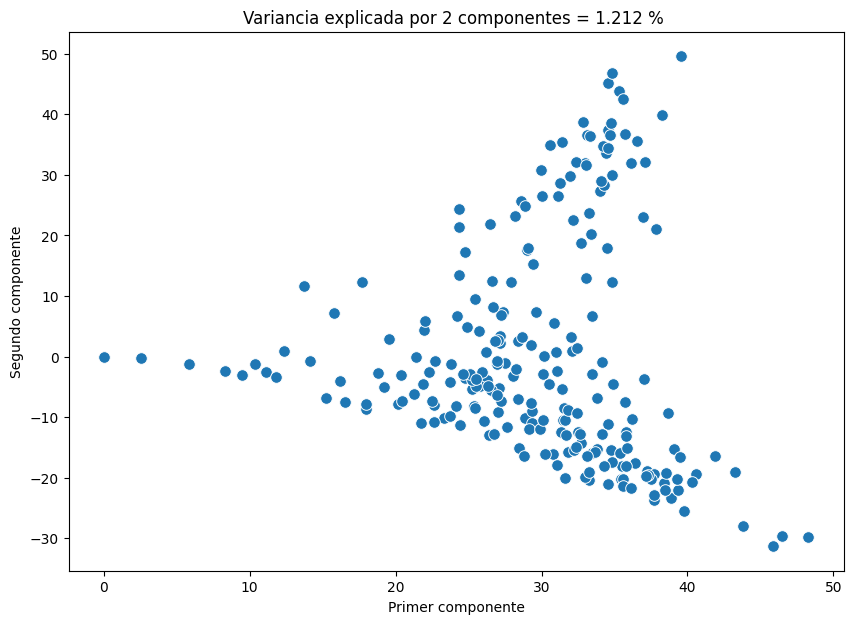

In [25]:
plt.figure(figsize=(10,7))
sns.scatterplot(x=dataReduction2[:,0], y=dataReduction2[:,1], s=70)
plt.title(f"Variancia explicada por 2 componentes = {round(sum(dimReduction2.explained_variance_ratio_ * 100),3)} % ")
plt.xlabel("Primer componente")
plt.ylabel("Segundo componente")

In [26]:
# Creamos instancia de la clase TruncatedSVD
dimReduction3 = TruncatedSVD(n_components = 3, random_state = 2)

# Ajustamos la transfromacion con nuestros datos
dimReduction3.fit(vectFitScaled)

# Reducimos la dimensionalidad
dataReduction3 = dimReduction3.transform(vectFitScaled)

print("Variancia explicada por 3 componentes = " \
        + str(sum(dimReduction3.explained_variance_ratio_ * 100)))

Variancia explicada por 3 componentes = 2.0259674871479287


Text(0.5, 0, 'Tercer componente')

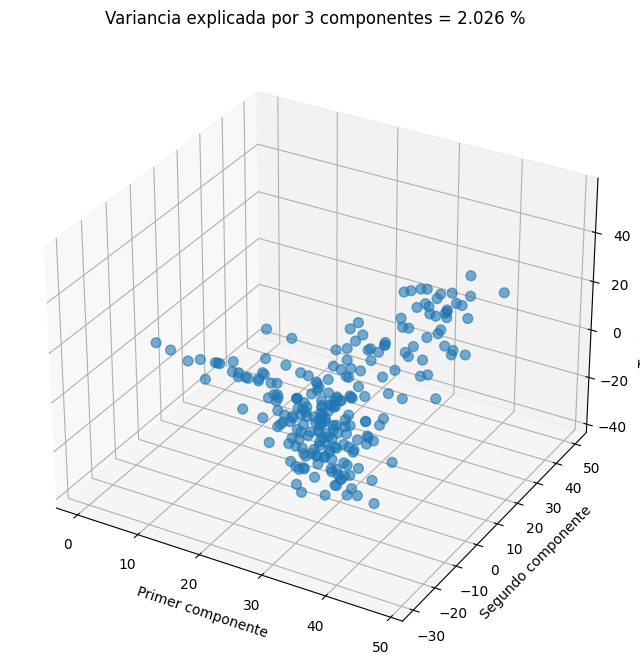

In [27]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
sctt = ax.scatter3D(dataReduction3[:,0], dataReduction3[:,1], dataReduction3[:,2], s=50, alpha = 0.6)
plt.title(f"Variancia explicada por 3 componentes = {round(sum(dimReduction3.explained_variance_ratio_ * 100),3)} % ", pad = 15)
ax.set_xlabel("Primer componente")
ax.set_ylabel("Segundo componente")
ax.set_zlabel("Tercer componente")

In [28]:
sumExpVariance = 0
for i in range(dimReduction.explained_variance_ratio_.shape[0]) :

    if (sumExpVariance > 0.95) :
        print(f"{i} componentes explican {round(sumExpVariance*100,3)} de la variancia")
        break

    sumExpVariance += dimReduction.explained_variance_ratio_[i]

212 componentes explican 95.016 de la variancia


Como podemos ver del análisis de componentes principales, no podemos sacar ninguna conclusión sobre la cantidad de tópicos del corpus. 

# Model LDA y su análisis

Gráfica wordCloud

c:\Users\julio\AppData\Local\Programs\Python\Python310\lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)
c:\Users\julio\AppData\Local\Programs\Python\Python310\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\julio\AppData\Local\Programs\Python\Python310\lib\site-packages\wordcloud\wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
c:\Users\julio\AppData\Local\Programs\Python\Python310\lib\site-packages\w

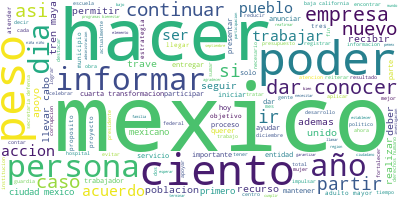

In [29]:
long_string = ','.join(list(textoPrueba['description'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

Estandarizamos la matriz para meterla al LDA

In [30]:
scaler = MaxAbsScaler()
scaler.fit(vectFit)
vectFitStandardized = scaler.transform(vectFit)

In [31]:
print(vectFitStandardized[1])

  (0, 196)	0.9999999999999999
  (0, 18587)	1.0
  (0, 20131)	1.0
  (0, 16588)	1.0
  (0, 24690)	1.0
  (0, 10147)	1.0
  (0, 13303)	1.0
  (0, 6462)	0.9999999999999999
  (0, 2091)	0.9999999999999999
  (0, 17251)	1.0
  (0, 17697)	1.0
  (0, 26897)	1.0
  (0, 14035)	1.0
  (0, 22790)	1.0
  (0, 23781)	0.9999999999999999
  (0, 2265)	0.9999999999999999
  (0, 13246)	0.9999999999999999
  (0, 22785)	0.9999999999999999
  (0, 19920)	0.9999999999999999
  (0, 5240)	0.9999999999999999
  (0, 18992)	1.0
  (0, 30214)	0.9999999999999999
  (0, 18351)	1.0
  (0, 28778)	1.0
  (0, 3029)	1.0
  :	:
  (0, 26553)	1.0
  (0, 6455)	1.0
  (0, 26377)	0.5041972014779104
  (0, 13237)	0.9999999999999999
  (0, 19916)	0.944205654510725
  (0, 25180)	0.511530307672027
  (0, 8131)	0.9999999999999999
  (0, 12597)	1.0
  (0, 17286)	1.0
  (0, 24446)	1.0
  (0, 21165)	0.3606048047669106
  (0, 11863)	0.45350873799699976
  (0, 12614)	1.0
  (0, 24222)	0.9978186068474881
  (0, 18524)	0.3852127521005288
  (0, 9011)	0.9800186102227469
  (0, 92

### Obtención de palabras clave usando TF-IDF

In [32]:
def extract_keywords(document):
    # Obtener el vocabulario de términos
    feature_names = vect.get_feature_names_out()

    # Obtener las frecuencias de términos en el documento
    doc_freqs = vect.transform([document]).toarray()[0]

    # Crear una lista de tuplas que contienen el término y su frecuencia en el documento
    doc_term_freqs = [(feature_names[i], doc_freqs[i]) for i in range(len(feature_names))]

    # Ordenar la lista de tuplas por la frecuencia descendente
    doc_term_freqs_sorted = sorted(doc_term_freqs, key=lambda x: x[1], reverse=True)

    # Obtener las 10 palabras clave más importantes para el documento
    doc_keywords = [term for term, freq in doc_term_freqs_sorted[:10]]

    # Unir las palabras clave en una cadena separada por comas
    keywords_str = ', '.join(doc_keywords)

    return keywords_str

# Aplicar la función a cada documento en el dataframe y asignar los resultados a una nueva columna
textoPrueba['keywords'] = textoPrueba['description'].apply(extract_keywords)
textoPrueba

,description,keywords
0,andres manuel lopez obrador ofrecer primero co...,"matutino salon, matutino salon tesoreria, pala..."
1,mañana dar conocer trabajo coordinado mexico c...,"gratuito calidad, acceso seguridad, acceso seg..."
2,presupuesto planeado cumplir compromiso garant...,"nominal, universidad publico, salario, salario..."
3,celebrar aprobacion presupuesto egresos federa...,"alonso senador, alonso senador rafael, erika a..."
4,primero conferencia matutino año presentar con...,"hacer publico, informacion, digno, transparenc..."
...,...,...
228,informe semanal avance construccion tren maya ...,"palenque, iberdrola, tren maya, maya, tren, dr..."
229,gracias pueblo mexico apoyo preocupacion muest...,"formar parte secretaria, parte secretaria, ins..."
230,informe semanal tren maya reafirmar proyecto r...,"fentanilo, mayo, droga, logro, innovacion, mer..."
231,pueblo autoridad respaldar construccion tren m...,"poder judicial, casino, judicial, olmeco, arqu..."


### LDA

In [33]:
# Crear una instancia de LatentDirichletAllocation con 10 componentes y un estado aleatorio de 42
LDA = LatentDirichletAllocation(n_components=10, random_state=42)

# Ajustar el modelo LDA a la matriz de vectores TF-IDF escalados (vectFitScaled)
LDA.fit(vectFitStandardized)

# Obtener la longitud de la lista de palabras clave (features) de la vectorización
len(vect.get_feature_names_out())

# Obtener las palabras clave más importantes para el primer tópico
single_topic = LDA.components_[0]

# Recorrer todos los tópicos y obtener las palabras clave más importantes para cada uno
for index, topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([vect.get_feature_names_out()[i] for i in topic.argsort()[-30:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['mostrar costo promedio', 'ademas mostrar costo', 'costo promedio gas', 'mejia', 'subsecretario seguridad publica', 'ricardo mejia berdeja', 'mejia berdeja', 'berdeja', 'ricardo mejia', 'promedio gas lp', 'promedio gas', 'ademas mostrar', 'profeco', 'cada lunes', 'informe', 'comparativo', 'gas lp', 'lp', 'ricardo sheffield', 'sheffield', 'ricardo', 'sheffield padilla', 'ricardo sheffield padilla', 'padilla', 'padilla exponer comparativo', 'exponer comparativo', 'exponer comparativo precio', 'padilla exponer', 'sheffield padilla exponer', 'comparativo precio']


THE TOP 15 WORDS FOR TOPIC #1
['educacion', 'guardia', 'compromiso', 'cabo', 'llevar cabo', 'diario', 'autoridad', 'reunir', 'respeto derechos', 'respeto derechos humanos', 'dar cuenta', 'elemento', 'cuenta', 'terminar', 'proposito', 'destinar', 'mejorar', 'realizar', 'llevar', 'confianza', 'contribuir', 'proceso', 'diverso', 'campaña', 'ciudad', 'institucion', 'aumentar', 'causa', 'partir', 'ir']


In [34]:

# Obtener las probabilidades de los tópicos para cada documento
topic_results = LDA.transform(vectFitStandardized)

# Asignar el tópico dominante a cada documento
textoPrueba['Main Topic'] = topic_results.argmax(axis=1)

# Obtener la distribución de tópicos para cada documento
topic_distribution = LDA.transform(vectFitStandardized)

# Agregar la distribución de tópicos como columnas en el DataFrame df
for i in range(topic_distribution.shape[1]):
    textoPrueba[f'Topic_{i}'] = topic_distribution[:, i]

# Mostrar el dataframe con la columna "Topic" agregada
display(textoPrueba)

,description,keywords,Main Topic,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,andres manuel lopez obrador ofrecer primero co...,"matutino salon, matutino salon tesoreria, pala...",0,0.982004,0.002000,0.001999,0.002000,0.002000,0.001999,0.001999,0.001999,0.002000,0.002000
1,mañana dar conocer trabajo coordinado mexico c...,"gratuito calidad, acceso seguridad, acceso seg...",4,0.000717,0.000717,0.000717,0.000717,0.993545,0.000717,0.000717,0.000717,0.000717,0.000717
2,presupuesto planeado cumplir compromiso garant...,"nominal, universidad publico, salario, salario...",0,0.994595,0.000601,0.000601,0.000601,0.000601,0.000601,0.000601,0.000601,0.000601,0.000601
3,celebrar aprobacion presupuesto egresos federa...,"alonso senador, alonso senador rafael, erika a...",2,0.000476,0.000476,0.995717,0.000476,0.000476,0.000476,0.000476,0.000476,0.000476,0.000476
4,primero conferencia matutino año presentar con...,"hacer publico, informacion, digno, transparenc...",9,0.000603,0.000603,0.000603,0.000603,0.000603,0.000603,0.000603,0.000603,0.000603,0.994574
...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,informe semanal avance construccion tren maya ...,"palenque, iberdrola, tren maya, maya, tren, dr...",4,0.000177,0.000177,0.000177,0.000177,0.998407,0.000177,0.000177,0.000177,0.000177,0.000177
229,gracias pueblo mexico apoyo preocupacion muest...,"formar parte secretaria, parte secretaria, ins...",0,0.995422,0.000509,0.000509,0.000509,0.000509,0.000509,0.000509,0.000509,0.000509,0.000509
230,informe semanal tren maya reafirmar proyecto r...,"fentanilo, mayo, droga, logro, innovacion, mer...",4,0.000150,0.000150,0.000150,0.000150,0.998651,0.000150,0.000150,0.000150,0.000150,0.000150
231,pueblo autoridad respaldar construccion tren m...,"poder judicial, casino, judicial, olmeco, arqu...",6,0.444046,0.000168,0.000168,0.000168,0.000168,0.000168,0.554612,0.000168,0.000168,0.000168


Porcentaje de importancia de cada tópico  por todas las semanas

In [35]:
my_dict = {}  

for i in range(topic_distribution.shape[1]):
    key = f"tópico {i}"  
    value = textoPrueba[f'Topic_{i}'].sum()  
    my_dict[key] = value  

# Print all the keys and values
for key, value in my_dict.items():
    print(str(key) + ": " + str(round(value,3)))

# Find the lowest and highest values
lowest_value = min(my_dict.values())
lowest_key = min(my_dict, key=my_dict.get)
highest_value = max(my_dict.values())
highest_key = max(my_dict, key=my_dict.get)

print("El " + str(lowest_key) + " fue el menos recurrente.")
print("El " + str(highest_key) + " fue el más recurrente.")

tópico 0: 47.391
tópico 1: 16.362
tópico 2: 7.536
tópico 3: 24.071
tópico 4: 60.04
tópico 5: 8.667
tópico 6: 5.608
tópico 7: 10.767
tópico 8: 33.755
tópico 9: 18.802
El tópico 6 fue el menos recurrente.
El tópico 4 fue el más recurrente.


### LDA vis

In [36]:
# Tokenizar los documentos utilizando el tokenizador de Penn Treebank
tokenizer = TreebankWordTokenizer()
documentos = []
for documento in textoPrueba['description'].tolist():
    tokens = tokenizer.tokenize(documento)
    documentos.append(tokens)

# Crear un diccionario de términos a partir de los documentos
dictionary = corpora.Dictionary(documentos)

# Crear una representación de la bolsa de palabras de los documentos
corpus = [dictionary.doc2bow(documento) for documento in documentos]

# Entrenar un modelo LDA con 10 tópicos
model_lda = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

# Crear una visualización con pyLDAvis
vis = pyLDAvis.gensim_models.prepare(model_lda, corpus, dictionary)
pyLDAvis.display(vis)


c:\Users\julio\AppData\Local\Programs\Python\Python310\lib\site-packages\pyLDAvis\_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
